In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-whitegrid')
%matplotlib inline
import pickle
from collections import defaultdict
import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pd.set_option('max_rows', 10)
pd.set_option('max_columns', 30)
pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)

In [145]:
import warnings
warnings.filterwarnings("ignore")

In [146]:
# # Change format of charts to .svg
%config InlineBackend.figure_format = 'svg'

In [147]:
%xmode Plain

Exception reporting mode: Plain


In [148]:
df = pd.read_csv('data/clean_data_encoded_for_regression.csv')

X = df[['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'avg_monthly_charges', 'internet_service-fiber_optic',
       'internet_service-no', 'contract-one_year', 'contract-two_year',
       'payment_method-credit_card_auto', 'payment_method-electronic_check',
       'payment_method-mailed_check']]

y = df['churn']

# Stratify our train-test-split so that we have a balanced split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

#### Upsample with SMOTE to get a balanced dataset

Currently, only 27% of our dataset is categorized as "Churn" (i.e., will leave the telecom company and no longer be a customer this month). In order to train our model better, we are upsampling with SMOTE so that 50% of our dataset is categorized as "Churn". This makes sense because we are more concerned about recall (making sure our model catches nearly everyone who is likely to churn) than it is about precision.

The rationale? It's much cheaper to keep an existing customer than to acquire a new one.

In [5]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(y_train.value_counts(), np.bincount(y_res))

NameError: name 'y_res' is not defined

### Let's do some quick and dirty analyses to determine which models we should tune further

In [152]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain,ytrain),model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc','Test Acc'])).mean()

new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# pred = new_model.predict(X_test)
# Do the test 10 times with a LinearSVC and get the average score
print(quick_test_a_few_times(new_model, X_train, y_train))

Train Acc    0.801771
Test Acc     0.802505
dtype: float64


In [153]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {mod.score(X_train, y_train)}')
    print(f'Test accuracy: {mod.score(X_test, y_test)}')
    print(f'Precision: {precision_score(y_test, predictions)}')
    print(f'Recall: {recall_score(y_test, predictions)}')
    print('\n')
    print(classification_report(y_test, predictions))

#### Decision Tree

In [10]:
decisiontree = DecisionTreeClassifier()
quick_test_a_few_times(decisiontree, X_train, y_train)

Train Acc    0.998241
Test Acc     0.724470
dtype: float64

#### Random Forests

In [11]:
randomforest = RandomForestClassifier()
quick_test_a_few_times(randomforest, X_train, y_train)

Train Acc    0.982257
Test Acc     0.794413
dtype: float64

#### Gradient Boosting Classifier

In [12]:
gradboost = GradientBoostingClassifier()
quick_test_a_few_times(gradboost, X_train, y_train)

Train Acc    0.846648
Test Acc     0.806719
dtype: float64

#### AdaBoost Classifier

In [13]:
adaboost = AdaBoostClassifier()
quick_test_a_few_times(adaboost, X_train, y_train)

Train Acc    0.815772
Test Acc     0.807001
dtype: float64

#### Logistic Regression

In [14]:
logreg = LogisticRegression()
quick_test_a_few_times(logreg, X_train, y_train)

Train Acc    0.809645
Test Acc     0.809406
dtype: float64

#### Linear SVC (Support Vector Classifier)

In [15]:
linearsvc = LinearSVC()
quick_test_a_few_times(linearsvc, X_train, y_train)

Train Acc    0.601122
Test Acc     0.605587
dtype: float64

#### SVC with rbf kernel

In [155]:
svc_rbf = SVC(kernel='rbf')
quick_test_a_few_times(svc_rbf, X_train, y_train)

Train Acc    0.949173
Test Acc     0.758971
dtype: float64

#### SVC with Polynomial kernel

In [ ]:
svc_poly = SVC(kernel='poly')
quick_test_a_few_times(svc_poly, X_train, y_train)

#### Naive Bayes Classifier

In [ ]:
naive_bayes = GaussianNB()
quick_test_a_few_times(naive_bayes, X_train, y_train)

# Using a kernel can do better:

In [17]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train, y_train)
pred = model.predict(X_test)

quick_test_a_few_times(model, X_train, y_train)

Train Acc    0.830179
Test Acc     0.802405
dtype: float64

In [18]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
model.fit(X_train, y_train)
pred = model.predict(X_test)

quick_test_a_few_times(model, X_train, y_train)

Train Acc    0.832454
Test Acc     0.800919
dtype: float64

In [19]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
coeffs = decisiontree.feature_importances_ # it's a percentage

list_of_coeffs = list(sorted(zip(coeffs, X.columns)))

In [20]:
import pprint
pprint.pprint(list_of_coeffs)

[(0.0026422957613580693, 'phone_service'),
 (0.008523307050197288, 'contract-one_year'),
 (0.008610254118002241, 'streaming_movies'),
 (0.008747912285878075, 'internet_service-no'),
 (0.009272394716996316, 'payment_method-credit_card_auto'),
 (0.0100013721102256, 'contract-two_year'),
 (0.01147854127240139, 'dependents'),
 (0.012519700229340276, 'streaming_tv'),
 (0.012762232038308386, 'payment_method-mailed_check'),
 (0.013433751561728343, 'partner'),
 (0.01343612168094617, 'online_backup'),
 (0.013545502574164885, 'tech_support'),
 (0.014668185584106324, 'online_security'),
 (0.015552503392837565, 'device_protection'),
 (0.01603243962822129, 'multiple_lines'),
 (0.01789145562480863, 'senior'),
 (0.019949856914850544, 'gender'),
 (0.02171505421459974, 'paperless_billing'),
 (0.039997970753775196, 'payment_method-electronic_check'),
 (0.0938460187205381, 'internet_service-fiber_optic'),
 (0.13377637460795125, 'monthly_charges'),
 (0.14185364837910505, 'total_charges'),
 (0.167849873272

In [21]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

[(0.0026422957613580693, 'phone_service'),
 (0.008523307050197288, 'contract-one_year'),
 (0.008610254118002241, 'streaming_movies'),
 (0.008747912285878075, 'internet_service-no'),
 (0.009272394716996316, 'payment_method-credit_card_auto'),
 (0.0100013721102256, 'contract-two_year'),
 (0.01147854127240139, 'dependents'),
 (0.012519700229340276, 'streaming_tv'),
 (0.012762232038308386, 'payment_method-mailed_check'),
 (0.013433751561728343, 'partner'),
 (0.01343612168094617, 'online_backup'),
 (0.013545502574164885, 'tech_support'),
 (0.014668185584106324, 'online_security'),
 (0.015552503392837565, 'device_protection'),
 (0.01603243962822129, 'multiple_lines'),
 (0.01789145562480863, 'senior'),
 (0.019949856914850544, 'gender'),
 (0.02171505421459974, 'paperless_billing'),
 (0.039997970753775196, 'payment_method-electronic_check'),
 (0.0938460187205381, 'internet_service-fiber_optic'),
 (0.13377637460795125, 'monthly_charges'),
 (0.14185364837910505, 'total_charges'),
 (0.167849873272

In [22]:
gradboost = GradientBoostingClassifier()
gradboost.fit(X_train, y_train)
gradboost.feature_importances_ # values are between 0 and 1, not normalized
gradboost.train_score_.mean()

0.7915874089757886

In [24]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

array([[ 5.44292671e-02,  6.08240350e-01,  5.97043419e-02,
        -1.83788841e-02, -7.19134521e-02, -2.93876716e-01,
        -4.16915259e-02, -3.90181005e-01,  3.33275332e-03,
         1.45727341e-01, -2.15357548e-01,  1.50485905e-01,
         6.86869109e-02,  2.27392684e-01,  2.25521753e-02,
         4.57393634e-04, -1.37068788e-02,  1.70980982e-01,
        -1.31143776e-01, -2.25346215e-01, -2.11696259e-01,
        -8.64605614e-02,  4.74030839e-02,  9.63616168e-02]])

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.coef_ # the abosulute value dictates importance

array([[-5.47002258e-02,  1.44570041e-01,  1.39597694e-01,
        -3.68460046e-01, -5.29459346e-02, -8.07437598e-01,
         3.05812917e-01, -4.17375606e-01, -2.30670059e-01,
        -1.35529917e-01, -3.39214982e-01,  1.97299648e-01,
         4.07409508e-02,  3.99717164e-01,  1.13964303e-02,
         1.85228808e-04,  2.90081317e-04,  4.75949545e-01,
        -6.09695939e-01, -6.03421988e-01, -1.03189956e+00,
        -1.23482566e-01,  3.75513895e-01,  6.21099178e-02]])

### ROC Curve

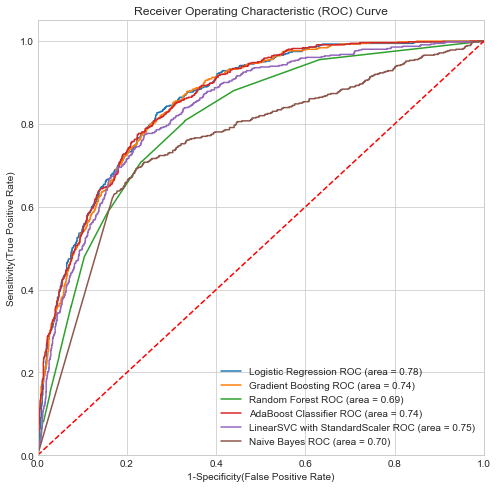

In [6]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': make_pipeline(StandardScaler(), LogisticRegression())
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'LinearSVC with StandardScaler',
    'model': make_pipeline(StandardScaler(), SVC(probability=True)),
},
{
    'label': 'Naive Bayes',
    'model': MultinomialNB()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_res, y_train_res) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.svg')

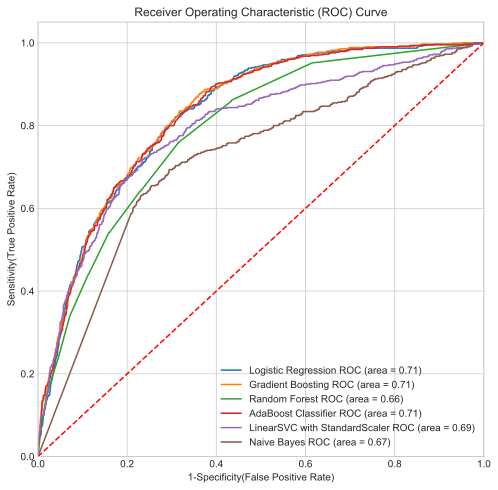

In [43]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'LinearSVC with StandardScaler',
    'model': make_pipeline(StandardScaler(), SVC(probability=True)),
},
{
    'label': 'Naive Bayes',
    'model': MultinomialNB()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.svg')

In [44]:
param_grid = {'C': [0.1, 10.]}

clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid=param_grid,
                                 cv=2,
                                 refit=True))

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [45]:
y_test

5405    1
1247    1
5414    1
6666    0
4073    0
       ..
842     1
6797    0
6831    0
7012    0
3974    0
Name: churn, Length: 2321, dtype: int64

In [46]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1701
           1       0.62      0.55      0.58       620

   micro avg       0.79      0.79      0.79      2321
   macro avg       0.73      0.71      0.72      2321
weighted avg       0.78      0.79      0.79      2321



In [48]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [49]:
1869/(5163+1869)

0.26578498293515357

In [50]:
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid={'C': [0.1, 1.0, 10.]},
                                 cv=3,
                                 refit=True))

In [51]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [52]:
new_x = pd.DataFrame(X_train)

In [53]:
new_x.shape

(4711, 24)

In [54]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [55]:
new = clf.predict(new_x)

In [56]:
print(classification_report(y_test, new))

ValueError: Found input variables with inconsistent numbers of samples: [2321, 4711]

### Logistic Regression Tuning

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
param_grid = [{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'], 'clf__solver': ['liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5)
gs.fit(X_train, y_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
pred = gs.predict(X_test)

In [ ]:
gs.best_estimator_

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
print(confusion_matrix(y_test, pred))

In [ ]:
pred.shape

In [ ]:
ones_pred = np.ones(shape=(2321,))

### Price Regression - Linear

In [ ]:
X2 = df[['phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service-fiber_optic',
       'internet_service-no']]

y2 = df['monthly_charges']

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=28)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X2_train, y2_train)

In [ ]:
predictions = lr.predict(X2_test)

In [ ]:
lr.score(X2_test, y2_test)

In [ ]:
pprint.pprint(list(zip(lr.coef_, X2.columns)))

predicted_charges = lr.predict(X2)

In [ ]:
df['predicted_monthly_charges'] = lr.predict(X2)

In [ ]:
df.head()

In [ ]:
df['predicted_minus_actual_monthly_charges'] = df['monthly_charges'] - df['predicted_monthly_charges']

In [ ]:
df['predicted_minus_actual_monthly_charges'].describe()

In [ ]:
X2 = df[['phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service-fiber_optic',
       'internet_service-no']]

y2 = df['monthly_charges']

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=28)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X2_train, y2_train)

In [ ]:
predictions = lr.predict(X2_test)

In [ ]:
lr.score(X2_test, y2_test)

In [ ]:
pprint.pprint(list(zip(lr.coef_, X2.columns)))

predicted_charges = lr.predict(X2)

In [ ]:
df['predicted_monthly_charges'] = lr.predict(X2)

In [ ]:
df.head()

In [ ]:
df['predicted_minus_actual_monthly_charges'] = df['monthly_charges'] - df['predicted_monthly_charges']

In [ ]:
df['predicted_minus_actual_monthly_charges'].describe()

In [ ]:
# Results from best parameters:
# {'clf__C': 1.2, 'clf__class_weight': None, 'clf__solver': 'sag'}
predictions = gs.predict(X_test)
print(classification_report(y_test, predictions))

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

### Logistic Regression Tuning

In [8]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=11))])
param_grid = [{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=11, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [9]:
gs.best_params_

{'clf__C': 1.0, 'clf__solver': 'newton-cg'}

In [10]:
gs.best_score_

0.8129496402877698

In [ ]:
np.mean(gs.cv_results_['mean_train_score'])

In [24]:
pred = gs.predict(X_train)

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922



In [26]:
print(classification_report(y_train, pred))
for iprint(confusion_matrix(y_train, pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922

[[2619  995]
 [ 247 1061]]


In [108]:
gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

while i < 1.00:
    probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
    i += .01
print(f'Max net gain = {max(gain)}')

Max net gain = 125500


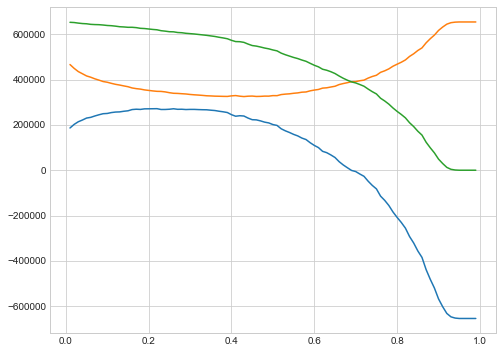

In [93]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

In [63]:
for i in range (0, 1, 0.01):
    print(i)

TypeError: 'float' object cannot be interpreted as an integer

**Calculating our total cost and total savings to get net gain:**

In [28]:
conf = confusion_matrix(y_train, pred)

In [33]:
total_cost = (conf[0][1] * 100) + (conf[1][1] * 100)
total_savings = conf[1][1] * 500

In [37]:
net_gain = total_savings - total_cost
print(net_gain)

324900


In [38]:
gs.score(X_train, y_train)

0.8111620795107034

In [39]:
coeffs = gs.best_estimator_.named_steps['clf'].coef_[0]
list_of_coeffs = list(sorted(zip(coeffs*10, X.columns)))

In [40]:
pprint.pprint(list_of_coeffs)

[(-16.42746912819217, 'tenure'),
 (-5.790720003273772, 'contract-two_year'),
 (-5.337871566609225, 'monthly_charges'),
 (-4.844027069738629, 'internet_service-no'),
 (-2.838500554911914, 'avg_monthly_charges'),
 (-2.455494228204468, 'contract-one_year'),
 (-1.3654337970686392, 'tech_support'),
 (-0.9574284575046683, 'online_security'),
 (-0.9170608586443882, 'dependents'),
 (-0.2933478756205609, 'phone_service'),
 (-0.19593316781517983, 'payment_method-credit_card_auto'),
 (-0.1878410141396891, 'online_backup'),
 (-0.17073452211921686, 'payment_method-mailed_check'),
 (-0.05356828416240757, 'partner'),
 (-0.04592066129180421, 'gender'),
 (0.23551414106809634, 'device_protection'),
 (0.9939067211625674, 'senior'),
 (1.4112801705767168, 'paperless_billing'),
 (1.7722906444050137, 'multiple_lines'),
 (1.9785955435757465, 'streaming_movies'),
 (2.2750484931311017, 'payment_method-electronic_check'),
 (2.6154931688697114, 'streaming_tv'),
 (6.861436030531189, 'internet_service-fiber_optic')

### Gradient Boosting Tuning

In [94]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
param_grid = [{'clf__learning_rate': [0.001, 0.1, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 150], 'clf__max_depth': [3,4,5]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.001, 0.1, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 150], 'clf__max_depth': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [100]:
gs.best_params_

{'clf__learning_rate': 0.1,
 'clf__loss': 'exponential',
 'clf__max_depth': 3,
 'clf__n_estimators': 100}

In [101]:
gs.best_score_

0.8074156059767571

In [ ]:
np.mean(gs.cv_results_['mean_train_score'])

In [104]:
gs.score(X_test, y_test)

0.6221033868092691

In [136]:
gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

while i < 1.00:
    folds = KFold(n_splits=5,shuffle=True)
    probs = cross_val_predict(gs.best_estimator_,X_train,obs,cv=folds,method='predict_proba',n_jobs=5)
    probs = pd.DataFrame(probs)
#     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
    i += .01
print(f'Max net gain = {max(gain)}')

Max net gain = 259700


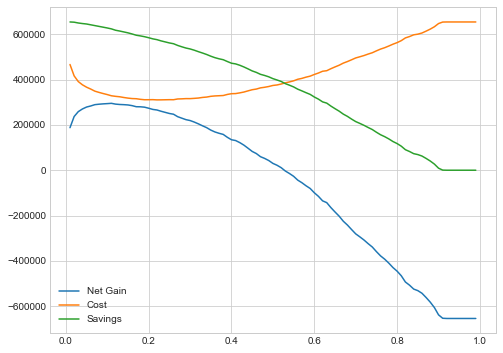

In [133]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

In [ ]:
coeffs = gs.best_estimator_.named_steps['clf'].coef_[0]
list_of_coeffs = list(sorted(zip(coeffs*10, X.columns)))

In [ ]:
pprint.pprint(list_of_coeffs)

### AdaBoost Tuning

In [111]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', AdaBoostClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME', 'SAMME.R'], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME', 'SAMME.R'], 'clf__n_estimators': [50, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [137]:
gs.best_params_

{'clf__algorithm': 'SAMME',
 'clf__learning_rate': 0.1,
 'clf__n_estimators': 100}

In [138]:
np.mean(gs.cv_results_['mean_train_score'])

0.833579248955054

In [139]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      3614
           1       0.50      0.78      0.61      1308

   micro avg       0.74      0.74      0.74      4922
   macro avg       0.70      0.75      0.71      4922
weighted avg       0.80      0.74      0.75      4922



In [140]:
# Test against our test set
gs.score(X_test, y_test)

0.7825311942959001

In [141]:
gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

while i < 1.00:
    folds = KFold(n_splits=5,shuffle=True)
    probs = cross_val_predict(gs.best_estimator_,X_train,obs,cv=folds,method='predict_proba',n_jobs=-1)
    probs = pd.DataFrame(probs)
#     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
    i += .01
print(f'Max net gain = {max(gain)}')

Max net gain = 258200


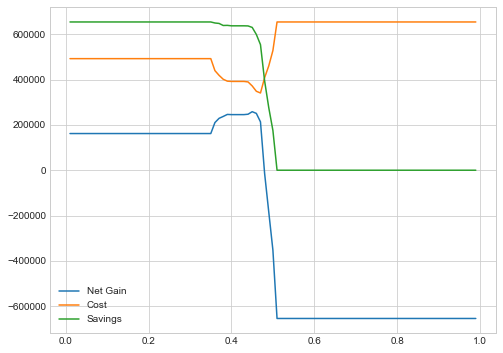

In [142]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

##  Cost minimization: 

In [42]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

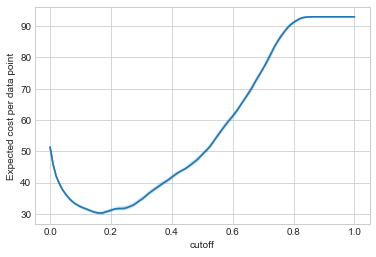

In [45]:
cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict
obs = y_train

K = 20
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(gs.best_estimator_,X_train,obs,cv=folds,method='predict_proba',n_jobs=5)[:,1]
    getcost = makecost(obs,prob,falsepos_cost=100,falseneg_cost=500)
    currentcost = getcost(cut)/X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [44]:
bestcut = cut[np.argmin(cost)]
bestcut

0.16161616161616163